# **CNN Cancer Detection**

## **Deep Learning**

### **1. Introduction:**
### Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.
### **Dataset**: a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. Task is to predict the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
### **Labels**: 1: Contains metastatic tissue, 0: Does not contain metastatic tissue
### **Data Characteristics**: Images: 96x96 pixels, Color Channels: 3 (RGB)


### **I use:**
#### **Image Handling** - Pillow for image processing, such as reading, resizing, and editing images.
#### **Deep Learning** - TensorFlow/Keras. I am working on a project involving image data, likely building and training a convolutional neural network (CNN)
#### **Sequential** - creating linear stack models where layers are added sequentially.
#### **Conv2D** - adding convolutional layers in CNN models
#### **MaxPooling2D** - pooling layers, reducing spatial dimensions in CNNs.
#### **EarlyStopping** - stopping training early when a monitored metric stops improving.
#### **ReduceLROnPlateau** - reducing the learning rate when a metric has stopped improving.

### **2. Import libraries:**

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## **3. Exploratory Data Analysis (EDA)**

### **3.1 Load DATA:**

In [2]:
# Paths to the data directories
train_dir = './data/histopathologic-cancer-detection/train/'
test_dir = './data/histopathologic-cancer-detection/test/'

# Load the labels
labels = pd.read_csv('./data/histopathologic-cancer-detection/train_labels.csv')

labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# data shape
shape = labels.shape

print(f'\n Histopathologic cancer detection dataset has {shape[0]} rows and {shape[1]} columns.\n')


 Histopathologic cancer detection dataset has 220025 rows and 2 columns.



In [4]:
# data columns info
labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


#### **Conclusion:** The data in train_labels.csv contains 2 columns: id and label and 220 025 rows

In [5]:
# data describe
labels.describe()


,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


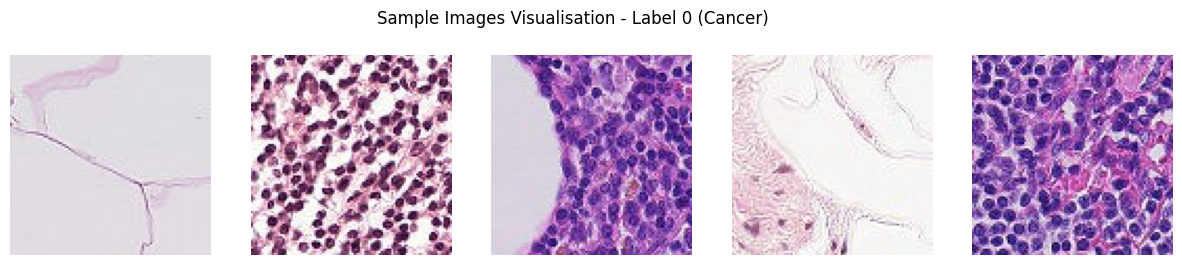

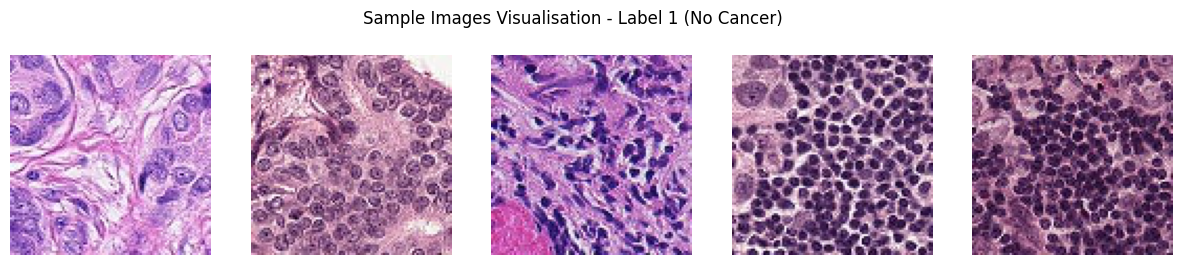

In [6]:
def show_images(label):
    descript = "Cancer" if label == 0 else "No Cancer"
    samples = labels[labels['label'] == label].sample(5)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, 5, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images Visualisation - Label {label} ({descript})')
    plt.show()

show_images(0)
show_images(1)

#### **Conclusion:** several examples visualisation from each class of the dataset—cancerous and non-cancerous.

### **3.2 Class Distribution**

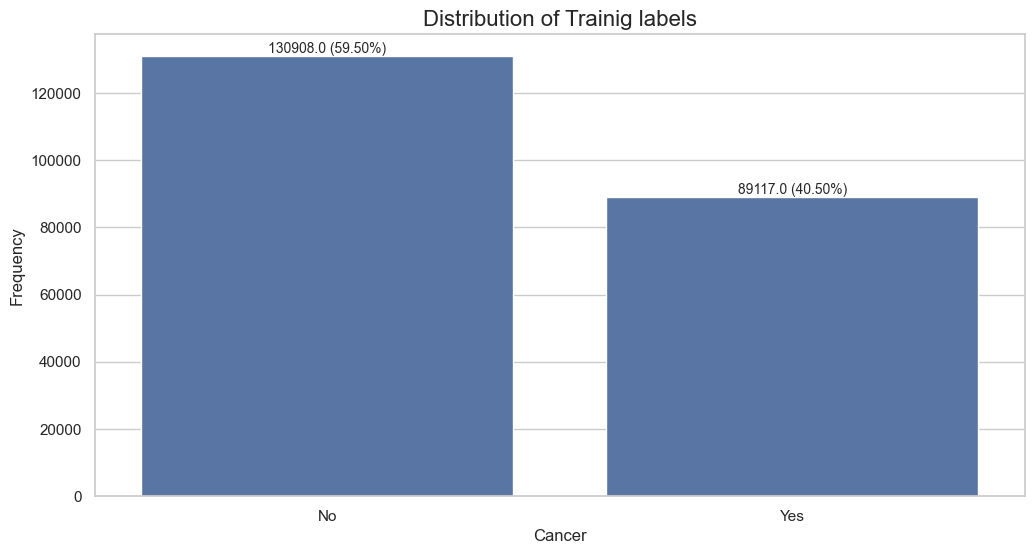

In [7]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x='label', data=labels)
total = len(labels)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height} ({height / total:.2%})', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Trainig labels', fontsize=16)
plt.xlabel('Cancer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.show()

#### **Conclusion:** As shown in the plot the data in train_labels.csv is **slightly inballanced**

### **3.3 Check for NULL values**

In [8]:
labels.isnull().sum()

id       0
label    0
dtype: int64

#### **Conclusion:** The data in train_labels.csv **does not contain null** values

### **3.4 Check for duplicated values**

In [9]:
#Check for duplicated values
labels.duplicated().sum()

0

#### **Conclusion:** The data in train_labels.csv **does not contain duplicated** values

### **3.5 Check for label column values**

In [10]:
labels['label'].unique()

array([0, 1], dtype=int64)

#### **Conclusion:** The column label in train_labels.csv **contains only 0 and 1** values

## **4. Prepare data**

### **4.1 Data Cleaning and Preprocessing**
#### **Data Augmentation** 
#### Goal: Address class imbalance and enrich the dataset.
#### Apply transformations like rotation, flipping, cropping, scaling, brightness/contrast adjustments, and random noise injection.
#### **Normalization**
#### Goal: Scale features for faster convergence and improved model performance.
#### For pixel values in images, scale to the range [0, 1] or [-1, 1] depending on the activation functions in your model.
#### **Data Splitting**
#### Goal: Ensure robust model evaluation by dividing data into training, validation, and test sets.
#### Standard Split Ratios

### **4.2 Model training**

#### Input Layer - The input images are of size 60x60 pixels with 3 color channels (RGB).
#### First Convolution + MaxPooling Layer - Applies 32 filters, each of size 3×33×3, to extract low-level features
#### Second Convolution + MaxPooling Layer - Similar to the first layer but with 64 filters to capture more complex patterns.
#### Third Convolution + MaxPooling Layer - Increases the number of filters to 128, learning even more abstract features.
#### Flattening - Flattens the 3D feature map output from the last pooling layer into a 1D vector, preparing it for the fully connected layers.
#### First Dense Layer - 128 neurons to learn non-linear combinations of the extracted features.
#### Output Layer - A single neuron with a sigmoid activation function to output probabilities for binary classification.

In [11]:
model = Sequential([
    # Input Layer
    Input(shape=(60, 60, 3)),

    # First Convolution + MaxPooling Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Second Convolution + MaxPooling Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third Convolution + MaxPooling Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flattening
    Flatten(),

    # First Dense Layer
    Dense(128, activation='relu'),

    # Output Layer
    Dense(1, activation='sigmoid')
    ])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,105 (1.92 MB)

 Trainable params: 503,105 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

#### **Conclusion:** defining a Convolutional Neural Network (CNN) model using the Keras Sequential API, designed for binary classification.

### **4.3 Data processing**

#### Preparing image data for training a deep learning model using Keras ImageDataGenerator:
####  - Preparing image data for binary classification.
####  - Using ImageDataGenerator to apply rescaling and augmentation and to load the data in batches.
####  - Creating separate data generators for training and validation data

In [12]:
labels['label'] = labels['label'].astype(str)
labels['label'] = labels['label'].astype(str)

labels['id'] = labels['id'].apply(lambda x: x + '.tif')

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    target_size = (60, 60),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training',
    shuffle = True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    target_size = (60, 60),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation',
    shuffle = True
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


#### **Optimizer**: Adam (Adaptive Moment Estimation) is an optimization algorithm that combines the advantages of both AdaGrad and RMSProp.
#### It adapts the learning rate during training and generally performs well in practice.
#### **Callbacks**: EarlyStopping and ReduceLROnPlateau are functions that are applied during training to improve performance or avoid overfitting.
#### **Model**: 
####  - Track the training loss and accuracy as well as the validation loss and accuracy.
####  - Stop early if the validation loss doesn't improve for 3 consecutive epochs.
####  - Reduce the learning rate if the validation loss plateaus for 2 consecutive epochs.

In [13]:
# hyperparameter tuning
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=7,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/7


C:\Users\azaza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1135s 206ms/step - accuracy: 0.7802 - loss: 0.4714 - val_accuracy: 0.8378 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 2/7
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 11:11 122ms/step - accuracy: 0.8125 - loss: 0.4231

C:\Users\azaza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - accuracy: 0.8125 - loss: 0.4231 - val_accuracy: 0.8388 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 3/7
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1154s 210ms/step - accuracy: 0.8397 - loss: 0.3642 - val_accuracy: 0.8627 - val_loss: 0.3215 - learning_rate: 0.0010
Epoch 4/7
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.9062 - loss: 0.3010 - val_accuracy: 0.8605 - val_loss: 0.3253 - learning_rate: 0.0010
Epoch 5/7
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 910s 166ms/step - accuracy: 0.8546 - loss: 0.3347 - val_accuracy: 0.8674 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 6/7
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 366s 67ms/step - accuracy: 0.9688 - loss: 0.2211 - val_accuracy: 0.8668 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 7/7
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1906s 346ms/step - accuracy: 0.8653 - loss: 0.3154 - val_accuracy: 0.8666 - val_loss: 0.3106 - learning_rate: 0.0010


Epoch 1: The model starts with an accuracy of 78.02% on the training set and 83.78% on the validation set, with a training loss of 0.4714 and a validation loss of 0.3613.

Epoch 2: Training accuracy increases to 81.25%, while the validation accuracy slightly improves to 83.88%. The training loss decreases further, showing progress, but both training and validation losses continue to improve.

Epoch 3: Training accuracy rises to 83.97%, and validation accuracy increases to 86.27%. The training loss continues to decrease, indicating the model is learning effectively.

Epoch 4: A significant increase in training accuracy to 90.62% occurs, while validation accuracy slightly drops to 86.05%. This indicates potential overfitting, as the model is improving its training performance but struggling to generalize on the validation data.

Epoch 5: The model shows a slight decrease in training accuracy to 85.46%, while validation accuracy increases to 86.74%. Both training and validation losses improve, suggesting the model is stabilizing.

Epoch 6: The training accuracy jumps to 96.88%, with validation accuracy remaining stable at 86.68%. While the model has reached a high training accuracy, the validation accuracy still does not improve significantly, indicating overfitting.

Epoch 7: The training accuracy stabilizes at 86.53%, with the validation accuracy at 86.66%. The model achieves consistent performance, though the validation accuracy remains relatively unchanged throughout the last few epochs.

### **4.4 Visualization**

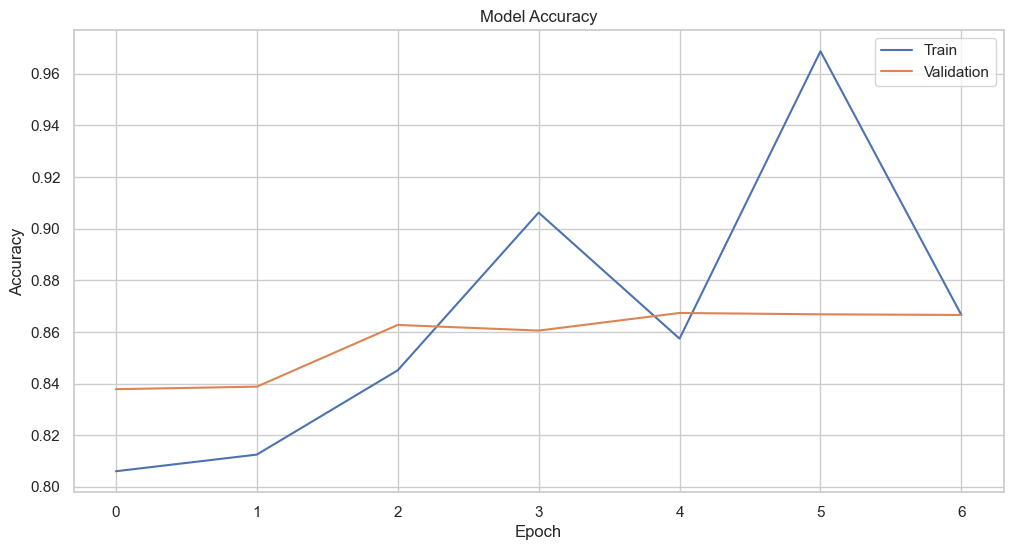

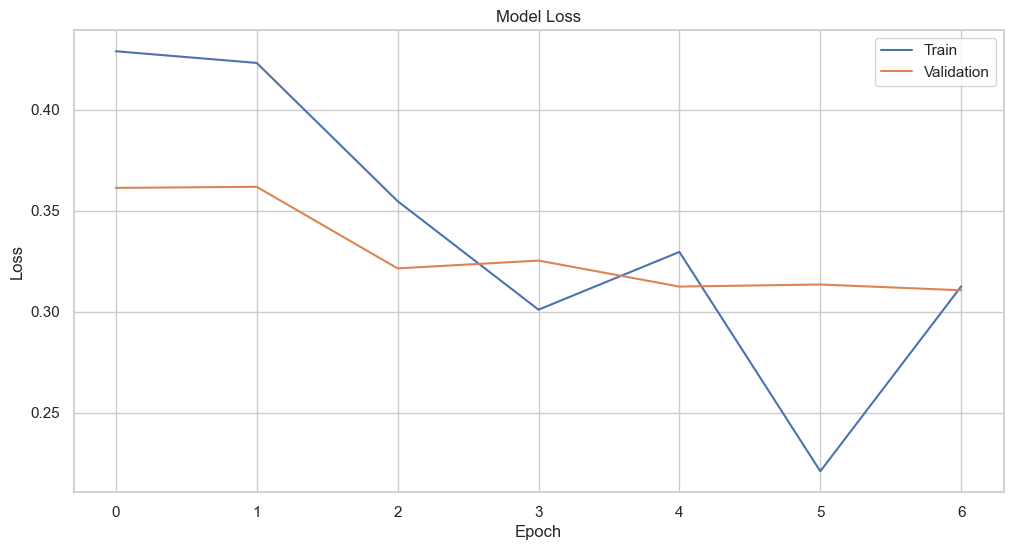

In [14]:
def plot_history(history, metric):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')

### **5. Conclusion**

#### Training accuracy improved steadily across epochs. The model learned to classify the training data effectively.
#### Training loss consistently decreased, but there were fluctuations in validation loss. Potential overfitting in some epochs.
#### But, Default parameters for the optimizer may not have been optimal, potentially capping performance.
#### **Future Improvements**
#### Add more augmentation techniques, such as rotation, brightness adjustment, and zoom, to further improve robustness.
#### Implement techniques like grid search or random search to optimize learning rate, batch size.
#### 